# Credit Card Fraud Detection

We obtain credit card data where each datapoint represents a specific transaction. Due to privacy concerns, a PCA is performed, and we are only given 28 dimensions, in addition to two quantitative variables. We wish to build a model that will predict whether a particular transaction was fraudulent or not.

Almost everyone uses a credit card nowadays, and security is a very important issue to both the consumers and the credit card companies. Fraudulent transactions can really disrupt a consumer's finances and day-to-day life. A good predictor can automatically decide whether a transaction is fraudulent, without having to cause too much trouble on the consumer's part.

As we will see, the data is highly unbalanced, so using accuracy might lead to a model that simply predicts that all transactions are not fraud. We probably want to focus more on recall that precision, since fraudulent transactions are very rare, and a false positive case is usually easy to resolve. Of course, we shouldn't bother consumers with too many false cases of credit card fraud. We will look both at the ROC curve and precision-recall curve, but the latter may be more useful due to the imbalanced nature of the dataset.

### Dataset:
This is a Kaggle project, so the data can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud. 

There are two quantitative variables, `time` and `Amount`, where `time` is the number of seconds since the first transaction in the dataset (`time = 0`). `Amount` is the dollar amount of the transaction. `Class` is a binary variable that indicates whether a particular transaction was fraud or not. The rest of the variables, `V1`-`V28`, are the resulting dimensions after a PCA was performed on the original data.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv("creditcard.csv")
display(data.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Analysis

In [7]:
desc = data.describe()
desc

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We see that there are 284,807 rows in the dataset. The last transaction in this dataset took place 172,792 seconds, about 48 days, after the first transaction in this dataset. The other explanatory quantitative variable is `Amount`, whose mean is 88 dollars and median is 22 dollars. Furthermore, all the other variables which correspond to principal components seem to be standardized: mean is close to zero, and standard deviation is close to 1. Let's quickly check for any missing variables.

In [8]:
# Check for missing data
for var in data.columns:
    if len(data[data[var].isnull()]) > 0:
        print(var)

Since nothing printed, this means that there are no missing data!

We know that this dataset is unbalanced. Let us see exactly the distribution of the data between fraud/not fraud. We see that only about 0.17% of the credit card transactions in this dataset are fraud! This mirrors reality: security is a very important issue and is continuously being improved; barely anyone ever makes a fraudulent transaction. 

In [10]:
n_fraud = len(data[data['Class'] == 1])
print('Number of Frauds in Dataset:', n_fraud)
print('Fraction of fraudulent transactions:', len(data[data['Class'] == 1]) / len(data))
print('Fraction of non-fraudulent transactions:', len(data[data['Class'] == 0]) / len(data))

Number of Frauds in Dataset: 492
Fraction of fraudulent transactions: 0.001727485630620034
Fraction of non-fraudulent transactions: 0.9982725143693799


For completeness, let's look at the distribution of the time variable. Since our dataset looks at transactions over a 48-day period, there is perhaps a periodic trend in the number of transactions over time, with a period of about 100,000 seconds, or about 27 days. However, we don't know much more about the data, i.e., perhaps this is a subset of credit card transactions so this periodic trend is only present in this case.

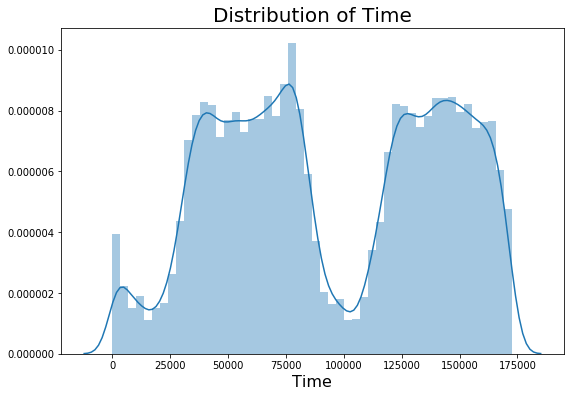

In [11]:
plt.figure(figsize=(9, 6))
plt.xlabel('Time', fontsize=16)
plt.title('Distribution of Time', fontsize=20)
sns.distplot(data['Time']);

Let's now take a look at the distribution of `Time` based on whether the transaction was fraud or not. To do this, we will make a violin plot. We see that the distributions are very similar: later we will judge from a correlation plot to determine if we shall keep this variable to use in our model.

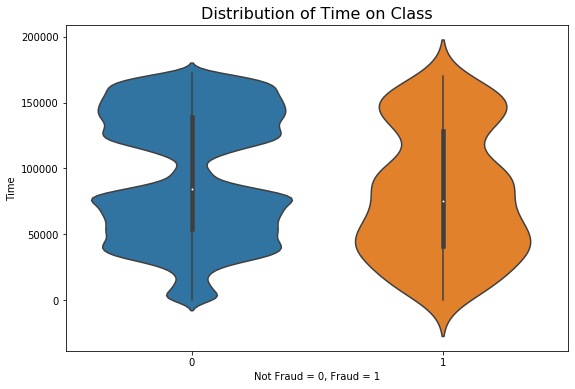

In [12]:
plt.figure(figsize=(9, 6))
plt.title('Distribution of Time on Class', fontsize=16)
sns.violinplot(x='Class', y='Time', data=data)
plt.xlabel('Not Fraud = 0, Fraud = 1');

Below is a boxplot of the `Amount` values. We see that it is highly skewed to the right, with the vast majority of transaction amounts close to zero. In fact, about 99% of the transactions in this dataset were less than 1000 dollars in amount.

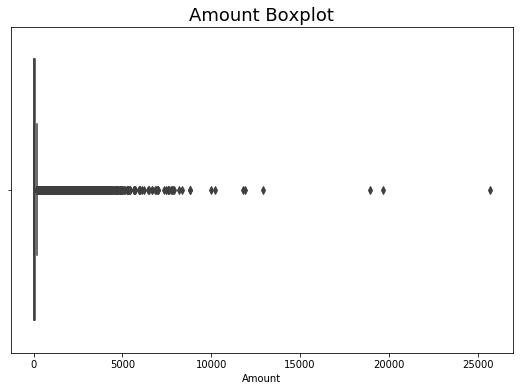

In [13]:
plt.figure(figsize=(9, 6))
plt.title('Amount Boxplot', fontsize=18)
sns.boxplot(data['Amount']);

In [14]:
# How many transactions were bigger than 1000 dollars?
print("Number of transactions bigger than 1000:", np.sum(data['Amount'] > 1000))
print("Fraction of transactions bigger than 1000:", np.sum(data['Amount'] > 1000) / len(data))

Number of transactions bigger than 1000: 2940
Fraction of transactions bigger than 1000: 0.010322779987851423


In [15]:
# Select the top 10 fraudulent examples by amount
data[data['Class'] == 1].sort_values(by='Amount', ascending=False)['Amount'][:10]

176049    2125.87
6971      1809.68
249167    1504.93
89190     1402.16
81609     1389.56
95597     1354.25
199896    1335.00
10690     1218.89
249239    1096.99
233258     996.27
Name: Amount, dtype: float64

Notice that the largest fraudulent transaction by amount was \\$2125, which is much less than the other outliers in this dataset. We have a very small amount of fraudulent transactions in this dataset, so should not remove any amount less than \\$2500. Indeed, let us drop all transactions more than \\$9,000 in amount.  

In [16]:
data = data[data['Amount'] <= 9000]
len(data)

284799

## Baseline Logistic Regression

A popular and effective technique in order to deal with such an imbalanced dataset is to perform undersampling: typical machine learning algorithms will not perform well on a dataset where 99.8% percent of the data are in the negative class. In fact, in this case, a useful baseline is to perform logistic regression on all the given variables in the original dataset.

In [17]:
# First, let's divide our data into training, validation, and test sets
from sklearn.model_selection import train_test_split

train, val_test = train_test_split(data, train_size=0.6, test_size=0.4, random_state=0)
validation, test = train_test_split(val_test, train_size=0.5, test_size=0.5, random_state=0)
print('Train-shape:', train.shape, 'Validation-shape:', validation.shape)

Train-shape: (170879, 31) Validation-shape: (56960, 31)


In [18]:
# We have to normalize the time and amount variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
time_amt = ['Time', 'Amount']
pcs = ['V'+str(i) for i in range(1,29)]
scaler.fit(train[time_amt])

def unbalanced_design_matrix(df):
    scaled = df[time_amt].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert numerical variables to standard units
    return pd.concat([scaled, df[pcs]], axis=1)

In [19]:
X_train, y_train = unbalanced_design_matrix(train), train['Class']
X_val, y_val = unbalanced_design_matrix(validation), validation['Class']
X_test, y_test = unbalanced_design_matrix(test), test['Class']
X_train.head(100)

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
108740,-0.500851,-0.360569,-0.431989,1.150225,1.726934,0.031913,-0.128153,-1.050595,0.803387,-0.158782,...,-0.117954,0.165908,-0.192283,-0.432479,0.004092,0.726350,-0.195630,0.046781,0.273810,0.126906
96477,-0.611668,-0.371637,-3.041658,4.530215,-4.831100,1.429618,-1.126920,-1.888479,-1.402149,2.536622,...,-1.037074,0.406079,-0.109072,-0.324957,0.564989,-0.323859,0.014442,-0.317870,0.359012,0.123533
65012,-0.914758,-0.367304,1.293858,0.095085,-1.176230,0.062001,2.198086,3.382319,-0.452285,0.800100,...,-0.101721,-0.021680,0.015728,-0.049825,-0.142924,1.007464,0.834357,-0.265176,0.021087,0.014889
39803,-1.155415,0.344821,-10.270488,-10.525218,0.677339,0.944721,3.789107,-3.178982,-1.296424,-0.544558,...,0.905219,-5.622812,-1.737482,1.991186,5.442806,0.369127,2.203534,0.255019,2.018340,0.105865
201585,0.824097,-0.371594,-0.093274,0.593930,-0.423499,1.429939,0.343469,-0.560313,0.149329,0.307291,...,0.663276,-0.226089,0.579828,1.932190,-0.066921,-0.010787,-1.197248,-0.331871,0.294764,0.220682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275703,1.513628,-0.369620,-0.661752,1.230091,-0.555843,-1.621747,1.393377,-1.178232,1.687391,-0.344203,...,-0.409534,-0.172064,0.153579,0.361403,-0.488245,0.477766,0.635021,0.129741,-0.030232,0.161386
257809,1.338165,-0.373781,-5.210639,3.930743,-3.801079,1.040547,-1.694489,-1.566911,-1.690764,3.129128,...,0.672971,-0.715336,0.014574,0.432303,0.725045,-0.116252,0.688640,-0.287800,0.228164,-0.030510
216889,0.965816,0.042940,1.881132,-0.092927,-1.839517,0.545691,0.325353,-0.934168,0.336862,-0.278309,...,-0.047438,0.051934,-0.308870,-0.992942,0.262978,0.630776,-0.301593,0.154605,-0.077237,-0.007984
107728,-0.510603,-0.290128,1.159818,0.056773,0.896468,0.969984,-0.876632,-0.936265,-0.055483,-0.157938,...,0.013338,-0.080504,-0.250770,-0.566745,0.126194,0.959658,0.275825,0.144492,-0.014337,0.025829


In [20]:
# Let's now perform logistic regression
from sklearn.linear_model import LogisticRegression

classifier_base = LogisticRegression(random_state=0)
classifier_base.fit(X_train, y_train)
classifications = classifier_base.predict(X_val)

print("Number of fraudulent cases in test set:", np.sum(y_val))
print("Number of predicted fraudulent cases:", np.sum(classifications))

/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Number of fraudulent cases in test set: 102
Number of predicted fraudulent cases: 67


Now we will measure the performance of this model through various ways. First, we will take a look at the ROC and precision-recall curves.

In [21]:
from sklearn import metrics

def curve_eval(y_true, probs, title_addition=""):
    """This function plots both the ROC and precision-recall curves for given 
       class values and predicted probabilities. They must both be one-dimensional
       vectors of the same shape."""
    
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
    plt.figure(figsize=(9,6))
    plt.plot(fpr, tpr)
    plt.title("ROC curve" + " " + title_addition, fontsize=18)
    plt.show()
    
    # Precision-recall curve
    precision, recall, _ = metrics.precision_recall_curve(y_true, probs)
    plt.figure(figsize=(9,6))
    plt.plot(recall, precision)
    plt.title("Precision-recall curve" + " " + title_addition, fontsize=18)
    plt.show()
    
    # Give area-under-the-curve scores
    print("AUC for ROC:", metrics.auc(fpr, tpr))
    print("AUC for precision-recall:", metrics.auc(recall, precision))

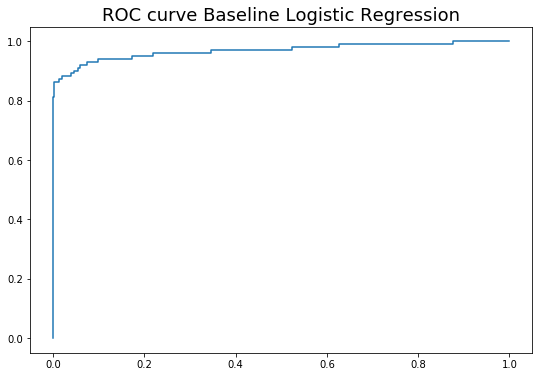

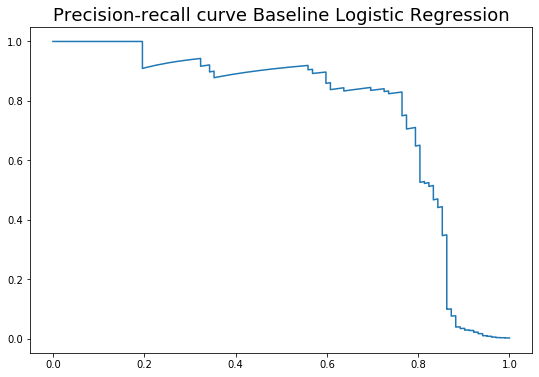

AUC for ROC: 0.9686934220028016
AUC for precision-recall: 0.7606863757576494


In [22]:
probs = classifier_base.predict_proba(X_val)
curve_eval(y_val, probs[:,1], title_addition="Baseline Logistic Regression")

From above, we notice that the ROC curve suggests that this model is actually quite good; however, the precision-recall curve shows that our classifier can definitely improve quite a bit. Indeed, below is a confusion matrix. In the test set, we know of $102$ fraudulent transactions, of which the classifier was able to detect $60$. On the other hand, of the $67$ times we predicted a fraudulent case, $7$ of them were not fraud. Thus:

$$\text{Baseline Performance:}$$

$$\text{Precision}=\frac{60}{67}=89.55\%$$

$$\text{Recall}=\frac{60}{102}=58.82\%$$

This is because the ROC curve, similar to accuracy, measures performance for __both__ classes (analogous to accuracy), while the precision-recall curve focuses on performance for the positive, or fraudulent, class. Since we prefer to identify fraudulent cases, unfortunately this performance is not too good, as the recall in this case is too close to 50%.

In [23]:
def make_confusion_matrix(y_true, preds):
    cf_mat = metrics.confusion_matrix(y_true, preds)
    df_cf_mat = pd.DataFrame(cf_mat)
    plt.figure(figsize = (9,7))
    sns.heatmap(df_cf_mat, annot=True, fmt="d", annot_kws={'size':20})
    plt.xticks([0.5, 1.5],labels=[0, 1])
    plt.yticks([0, 2],labels=[0, 1])
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show()

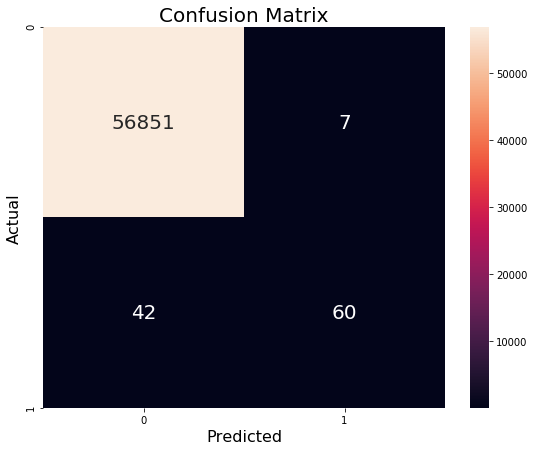

In [24]:
make_confusion_matrix(y_val, classifications)

## Feature Selection and Undersampling

The method of undersampling has become more popular in this current age of "big data." In the past, a popular technique was oversampling because collecting large amounts of data was indeed an issue. With too much data, particularly too much data in the majority class, this can be a nuisance. The idea is quite simple: randomly get rid of enough data in the majority class so that the resulting dataset is balanced. Note that this introduces bias since we train our model on only a subset of our entire dataset.

In [25]:
# Undersampling
n_fraud = len(train[train['Class'] == 1])
class0_samples = train[train['Class'] == 0].sample(n=n_fraud, random_state=0)

# Append to all fraud samples
frauds = train[train['Class'] == 1]
train_u = pd.concat([frauds, class0_samples], axis=0)
train_u

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
18466,29526.0,1.102804,2.829168,-3.932870,4.707691,2.937967,-1.800904,1.672734,-0.300240,-2.783011,...,-0.106994,-0.250050,-0.521627,-0.448950,1.291646,0.516327,0.009146,0.153318,0.68,1
149357,91075.0,-1.855061,1.554964,-1.405809,0.669327,-0.280230,1.178652,-3.459979,-2.815155,1.242229,...,-0.095308,0.946629,-0.297403,-0.368344,0.198731,-0.078591,0.366709,0.073767,38.76,1
238366,149640.0,0.754316,2.379822,-5.137274,3.818392,0.043203,-1.285451,-1.766684,0.756711,-1.765722,...,0.397058,0.141165,0.171985,0.394274,-0.444642,-0.263189,0.304703,-0.044362,2.00,1
15225,26585.0,-19.856322,12.095893,-22.464083,6.115541,-15.148022,-4.346724,-15.648507,13.276805,-3.974162,...,1.750730,-1.409636,-0.809809,0.121397,1.350300,-0.224292,1.597621,0.476920,99.99,1
143188,85181.0,-3.003459,2.096150,-0.487030,3.069453,-1.774329,0.251804,-4.328776,-2.425478,-0.985222,...,0.163967,1.245648,-0.269241,0.537102,-0.220757,-0.059555,0.460710,-0.033551,2.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50911,44704.0,0.989857,-0.912736,0.705872,-1.147671,-1.399277,-0.847855,-0.400770,-0.156833,1.767770,...,0.213874,0.605010,-0.247121,0.490739,0.467580,0.095699,0.024726,0.050992,150.00,0
266746,162473.0,1.935206,-0.264627,-0.295627,1.362489,-0.673414,-0.524312,-0.500896,0.095423,1.227252,...,-0.238875,-0.693892,0.410135,-0.230518,-0.475412,-0.965896,0.039391,-0.030345,12.89,0
257833,158362.0,-4.877630,-4.737007,0.628923,-0.671027,1.871279,0.453433,0.036347,0.230997,0.770132,...,-0.301219,1.129709,2.045700,-1.533579,0.913491,1.160164,0.579032,-0.091544,347.00,0
22644,32355.0,1.183009,1.354927,-1.450851,1.661738,0.977732,-1.518109,0.791569,-0.341303,-0.665438,...,-0.146889,-0.226449,-0.153613,0.110094,0.784310,-0.288983,0.065237,0.099550,0.75,0


Let's now perform feature selection to extract only the features that can best predict whether a transaction was fraudulent or not. To do this, we make a correlation heatmap and visually pick out the features that are most negatively/positively correlated with the `Class` variable.

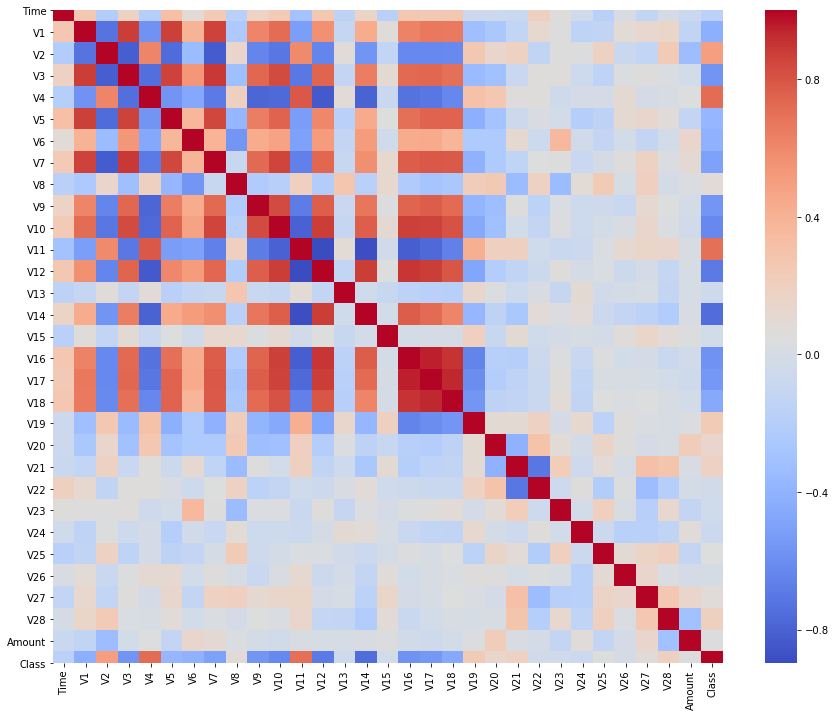

In [27]:
# Feature selection
# Make correlation heatmap to select the columns that are most positively/negatively correlated with
# whether the transaction was fraud or not
plt.figure(figsize=(15, 12))
sns.heatmap(train_u.corr(), cmap='coolwarm');

Below, we pick out the most effective explanatory variables, i.e. the ones that are most correlated with the `Class` variable. We pick an initial cutoff of a 0.4 positive/negative correlation.

In [121]:
corr_matrix = train_u.corr()
corr_matrix[corr_matrix['Class'].abs() > 0.4]['Class']

V1      -0.415033
V2       0.499860
V3      -0.566317
V4       0.716703
V6      -0.402934
V7      -0.500601
V9      -0.556435
V10     -0.623718
V11      0.699944
V12     -0.689327
V14     -0.754842
V16     -0.583193
V17     -0.548845
V18     -0.452977
Class    1.000000
Name: Class, dtype: float64

In [122]:
# We can just do this visually
# Negatively correlated variables:
neg_vars = ['V1', 'V3', 'V6', 'V7', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18']
# Positively correlated variables:
pos_vars = ['V2', 'V4', 'V11']

def design_matrix(df):
    return df[neg_vars + pos_vars]

Let's see some boxplots of some of these variables by fraud/not fraud. Indeed, these boxplots represent the correlations we see in the heatmap. For example, values for `V14` on average tend to be lower for fraudulent transactions than non-fraudulent transactions. Similarly, values for `V4` tend to be higher for frauds than non-frauds.

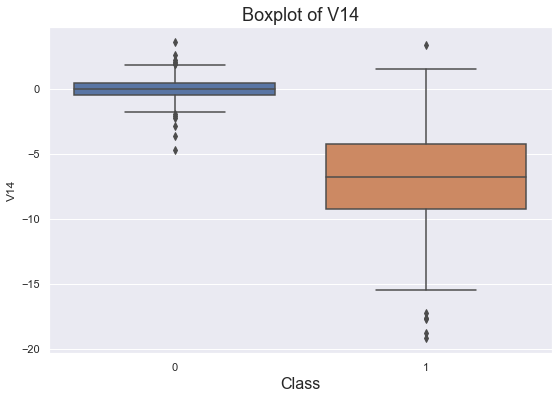

In [123]:
# V14
plt.figure(figsize=(9,6))
sns.boxplot(x='Class', y='V14', data=train_u)
plt.xlabel('Class', fontsize=16)
plt.title('Boxplot of V14', fontsize=18);

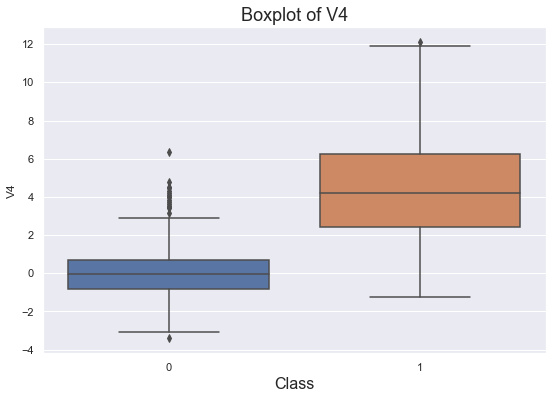

In [124]:
# V4
plt.figure(figsize=(9,6))
sns.boxplot(x='Class', y='V4', data=train_u)
plt.xlabel('Class', fontsize=16)
plt.title('Boxplot of V4', fontsize=18);

Below we project our data onto the principal components corresponding to `V4` and `V14` (the most correlated variables with `Class`), and make a scatterplot in order to better visualize the distribution of fraudulent/non-fraudulent transactions with respect to these two variables.

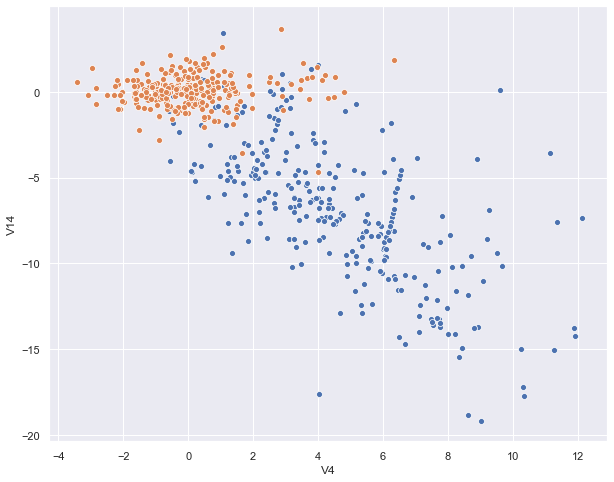

In [125]:
sns.set()
plt.figure(figsize=(10, 8))
two_vars = ['V4', 'V14']
train_u_pos = train_u[train_u['Class'] == 1][two_vars]
train_u_neg = train_u[train_u['Class'] == 0][two_vars]
sns.scatterplot(train_u_pos[two_vars[0]], train_u_pos[two_vars[1]])
sns.scatterplot(train_u_neg[two_vars[0]], train_u_neg[two_vars[1]])
plt.show()

## Logistic Regression with Undersampling

We now try to fit a logistic regression model on the undersampled data.

In [126]:
X_train_u, y_train_u = design_matrix(train_u.drop('Class', axis=1)), train_u['Class']
XX_val = design_matrix(X_val)

clf_u = LogisticRegression(random_state=0)
clf_u.fit(X_train_u, y_train_u)
preds = clf_u.predict(XX_val)

/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [127]:
# Accuracy seems pretty good, but it is misleading!
acc_val = np.mean(preds == y_val)
print("Accuracy:", acc_val)

Accuracy: 0.9696453651685393


Again, let's plot a ROC curve and a precision-recall curve, knowing that we prefer looking at the precision-recall curve.

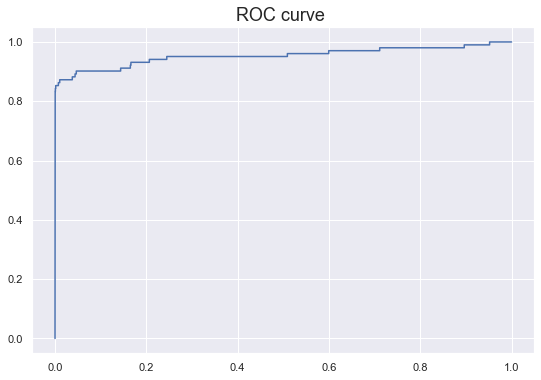

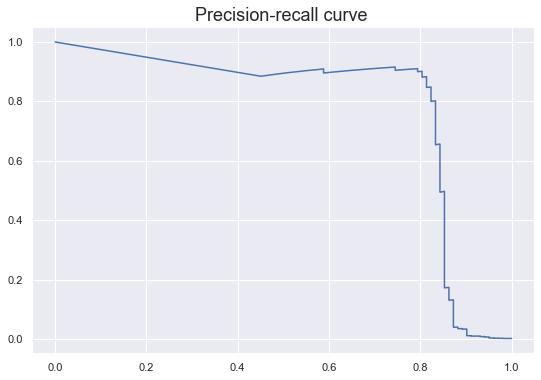

AUC for ROC: 0.953432838188566
AUC for precision-recall: 0.7843885652570051


In [128]:
probs = clf_u.predict_proba(XX_val)
curve_eval(y_val, probs[:,1])

It seems that the AUC for the precision-recall curve did increase slightly, but we indeed get similar performance looking at the top-right corner of the plot. We will use the validation set to find an optimal threshold value. From below, our recall improved quite a bit, but the precision is quite low.

$$\text{Validation With Undersampling:}$$

$$\text{Precision}=\frac{89}{89+1716}=4.93\%$$

$$\text{Recall}=\frac{89}{89+13}=87.25\%$$

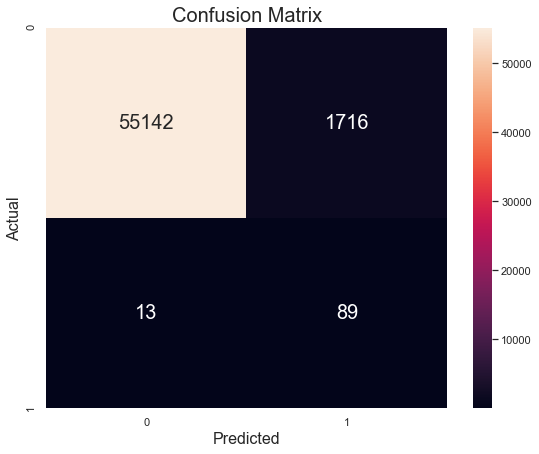

In [130]:
make_confusion_matrix(y_val, preds)

In [199]:
def threshold_reg_grid_search(X_train, y_train, X_val, y_val, thresholds, c_vals, penalty='l2'):
    for t in thresholds:
        for c in c_vals:
            if penalty=='l2':
                clf_ct = LogisticRegression(penalty=penalty, C=c, random_state=0, solver='lbfgs')
            else:
                clf_ct = LogisticRegression(penalty=penalty, C=c, random_state=0)
            clf_ct.fit(X_train, y_train)
            probs = clf_ct.predict_proba(X_val)
            preds = np.where(probs[:,1] > t, 1, 0)
            true_pos = np.sum((preds == y_val) & (preds == 1))
            recall = true_pos / np.sum(y_val)
            precision = true_pos / np.sum(preds)
            if recall > 0.86 and precision > 0.1:
                print("Threshold:", round(t, 2), "C:", c, "   Recall:", round(recall, 2), "   Precision:", round(precision, 2))
                

thresholds = np.arange(start = 0.1, stop = 1, step = 0.1)
c_vals = [0.01, 0.1, 1, 10, 100]
threshold_reg_grid_search(X_train_u, y_train_u, XX_val, y_val, thresholds, c_vals)

Threshold: 0.5 C: 0.01    Recall: 0.86    Precision: 0.13
Threshold: 0.6 C: 0.01    Recall: 0.86    Precision: 0.14
Threshold: 0.7 C: 0.1    Recall: 0.87    Precision: 0.12
Threshold: 0.8 C: 1    Recall: 0.87    Precision: 0.12
Threshold: 0.9 C: 1    Recall: 0.86    Precision: 0.15
Threshold: 0.9 C: 10    Recall: 0.87    Precision: 0.13
Threshold: 0.9 C: 100    Recall: 0.87    Precision: 0.13


From the script above, we see that the best performance seems to occur when we set the threshold at 0.9 and $C$ at 10. Note that depending on the company's/application's needs and desires, we can tune the threshold and $C$-value appropriately.

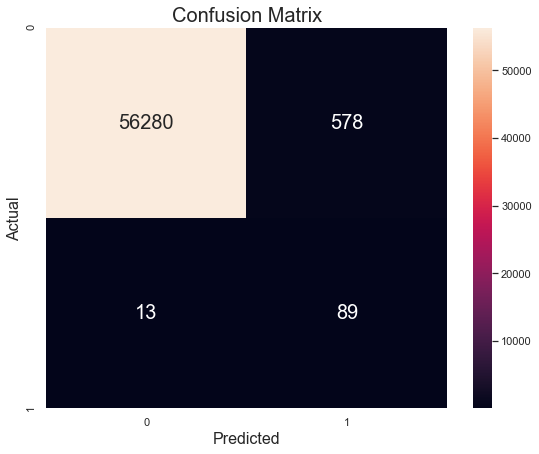

In [179]:
clf_u_opt = LogisticRegression(C=10, random_state=0, solver='lbfgs')
clf_u_opt.fit(X_train_u, y_train_u)
probs = clf_u_opt.predict_proba(XX_val)
preds = np.where(probs[:,1] > 0.9, 1, 0)
make_confusion_matrix(y_val, preds)

Finally, we see this model's performance on the test set. It suffices to look at the confusion matrix. Here, we get the following final results for the precision and recall.


$$\text{Final Test With Undersampling:}$$

$$\text{Precision}=\frac{84}{84+578}=12.7\%$$

$$\text{Recall}=\frac{85}{85+12}=87.6\%$$

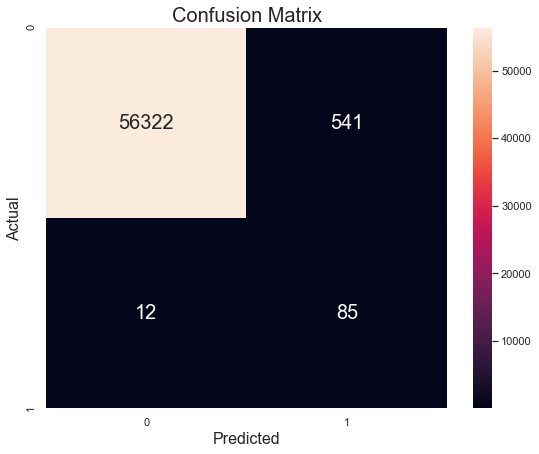

In [135]:
probs_test = clf_u_opt.predict_proba(design_matrix(X_test))
preds_test = np.where(probs_test[:,1] > 0.9, 1, 0)
make_confusion_matrix(y_test, preds_test)

A logistic regression model performs considerably well in detecting fraudulent samples as long as we perform the undersampling method. With undersampling, the recall considerably improves, although precision may decrease as a result. However, as in the test set, we notice that $541/(541+56322)=0.96\%$ of non-fraudulent transactions were flagged falsely as fraud. Of course, we could continue work in order to improve the performance of a classifier that both increases detection and decreases false positives.

## Logistic Regression using SMOTE

SMOTE stands for the synthetic minority oversampling technique. The name explains the method quite well: we will oversample the minority class in order to have more examples, in this case, of fraudulent credit card transactions. We will combine this with the undersampling technique we have done above.

The way the oversampling is done is as follows: to synthetically create an additional data point in the minority class, first we pick a point $x$ already in the minority class. Then, search for its five nearest neighbors in the minority class. We pick 5 because it is best practice, and this is the recommended number to use in the paper below. We uniformly at random choose one of these five datapoints, call it $x'.$ Finally, choose a random $\lambda\in (0,1)$ so that our added synthetic datapoint is 
$s=\lambda x+(1-\lambda)x'.$

In other words, we are simply picking two nearby minority-class data points, drawing a line between them, and randomly selecting a point on that line. Note that performing a nearest neighbor search is not easy, especially in high dimensions. We will use scikit-learn's Nearest Neighbors package in order to compute these. Before doing this, however, it is best to combine both undersampling and SMOTE, so that fitting the nearest neighbors algorithm will not take too long.

In [136]:
# We will perform undersampling exactly as done above, but we will add 100 synthetic 
# fraudulent transaction datapoints

n_fraud_smote = len(train[train['Class'] == 1]) + 400
class0_samples_smote = train[train['Class'] == 0].sample(n=n_fraud_smote, random_state=0)

# Append to all fraud samples
frauds_smote = train[train['Class'] == 1]
train_smote = pd.concat([frauds_smote, class0_samples_smote], axis=0)
train_smote

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
18466,29526.0,1.102804,2.829168,-3.932870,4.707691,2.937967,-1.800904,1.672734,-0.300240,-2.783011,...,-0.106994,-0.250050,-0.521627,-0.448950,1.291646,0.516327,0.009146,0.153318,0.68,1
149357,91075.0,-1.855061,1.554964,-1.405809,0.669327,-0.280230,1.178652,-3.459979,-2.815155,1.242229,...,-0.095308,0.946629,-0.297403,-0.368344,0.198731,-0.078591,0.366709,0.073767,38.76,1
238366,149640.0,0.754316,2.379822,-5.137274,3.818392,0.043203,-1.285451,-1.766684,0.756711,-1.765722,...,0.397058,0.141165,0.171985,0.394274,-0.444642,-0.263189,0.304703,-0.044362,2.00,1
15225,26585.0,-19.856322,12.095893,-22.464083,6.115541,-15.148022,-4.346724,-15.648507,13.276805,-3.974162,...,1.750730,-1.409636,-0.809809,0.121397,1.350300,-0.224292,1.597621,0.476920,99.99,1
143188,85181.0,-3.003459,2.096150,-0.487030,3.069453,-1.774329,0.251804,-4.328776,-2.425478,-0.985222,...,0.163967,1.245648,-0.269241,0.537102,-0.220757,-0.059555,0.460710,-0.033551,2.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254219,156632.0,2.006389,-0.528727,-0.558014,0.069515,-0.491254,-0.086976,-0.688956,0.042567,1.539668,...,0.158294,0.651051,0.126556,0.514068,-0.116418,0.107347,0.008454,-0.036399,17.95,0
246267,153104.0,-0.720522,0.867849,-1.925609,-1.788049,3.332040,2.873082,0.671837,1.035365,-1.145031,...,0.272783,0.517922,-0.386203,0.766883,0.598950,0.353061,-0.069111,0.002680,17.95,0
197297,131945.0,-0.576237,1.082302,-0.435705,-0.688156,1.374334,-0.907804,1.407457,-0.042162,-0.773974,...,0.007138,-0.002345,-0.539525,0.689038,1.261377,0.815593,0.053435,-0.014078,19.33,0
136382,81678.0,-1.076934,1.260707,-0.192460,1.233287,-3.242435,1.864497,4.031571,-1.951299,-0.376492,...,0.504870,0.221750,-0.185040,0.465599,-0.164749,-0.300267,-0.088894,-0.417848,721.00,0


In [137]:
# Fit a nearest neighbors model using sklearn
from sklearn.neighbors import NearestNeighbors

train_smote_frauds = train_smote[train_smote['Class'] == 1]
knn = NearestNeighbors(n_neighbors=5)
knn.fit(train_smote_frauds)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

The following function returns a list, where each list gives the 5 nearest neighbors of each point.

In [138]:
nearest_neighbors_list = knn.kneighbors(train_smote_frauds)[1]
display(nearest_neighbors_list[:10])
print("Length of nearest_neighbors_list:", len(nearest_neighbors_list))

array([[  0,  83,  11, 208, 153],
       [  1,  93, 102, 143, 111],
       [  2, 247, 278, 228,  49],
       [  3, 271, 182, 274, 162],
       [  4,   8, 145, 171, 214],
       [  5, 263, 168, 244, 173],
       [  6, 125,  95,  39, 127],
       [  7, 214,   8,   4, 171],
       [  8,   4, 171, 214, 145],
       [  9, 184, 281, 231, 172]])

Length of nearest_neighbors_list: 293


In [139]:
# Randomly select 100 indices
np.random.seed(0)
sample_inds = np.random.randint(low=0, high=293, size=400)
smote_nn_sample = nearest_neighbors_list[sample_inds]

smote_pairs = np.zeros((400, 2))
# Randomly select one of the five nearest neighbors for each point
for i in range(400):
    rand_ind = np.random.randint(low=1, high=5)
    smote_pairs[i] = [smote_nn_sample[i, 0], smote_nn_sample[i, rand_ind]]

# Randomly select 100 numbers between 0 and 1
sample_lambdas = np.random.uniform(low=0, high=1, size=400).reshape(400,1)

Now, we use the formula $s=\lambda x+(1-\lambda)x'$ to select our new synthetic points.

In [140]:
smotes0 = train_smote.iloc[smote_pairs[:,0],:]
smotes1 = train_smote.iloc[smote_pairs[:,1],:]
smotes = sample_lambdas * np.array(smotes0) + (1-sample_lambdas) * np.array(smotes1)
smotes = pd.DataFrame(smotes)
smotes.columns = train_smote.columns
display(smotes.head(5))
print(smotes.shape)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,7570.313565,0.219156,3.618396,-5.935302,5.990064,-0.123765,-3.144996,-2.313543,0.384292,-1.997734,...,0.421170,-0.426476,-0.156724,0.233443,0.442018,0.450754,0.694745,0.396941,1.000000,1.0
1,50788.995222,-9.037885,7.050088,-12.257938,4.233966,-7.129235,-3.355787,-7.964010,6.363295,-2.422891,...,0.924683,-0.798638,-0.083139,-0.043264,0.490092,-0.263013,1.161616,0.232114,99.990000,1.0
2,155749.351556,0.363518,3.079467,-5.099761,5.878839,0.549954,-1.737115,-1.265077,0.728815,-2.931922,...,0.107487,-0.690513,0.199769,-0.476871,-0.046350,0.129737,0.181965,-0.017247,1.978243,1.0
3,45717.409235,0.217675,0.744086,-0.851737,1.702032,-0.232961,-0.237724,-0.745812,0.444130,-0.246459,...,-0.019179,-0.607816,-0.105839,-0.692593,0.297961,-0.396614,0.163122,0.120951,70.927028,1.0
4,96667.332314,-14.040235,10.097698,-15.996132,9.980512,-10.908487,-0.409257,-18.522787,-3.963326,-6.750913,...,-3.424092,2.003286,1.109945,0.217444,-0.229696,0.271033,-2.605201,-0.404384,126.363523,1.0


(400, 31)


In [141]:
# Add the new synthetic datapoints to the dataframe!
train_smote = pd.concat([train_smote, smotes], axis=0)

In [156]:
# We will keep the same predictor variables as above.

X_train_smote, y_train_smote = design_matrix(train_smote), train_smote['Class']

# Let's also ensure that the classes are indeed balanced, or at least nearly balanced.
print("Fraction of fraudulent cases:", np.sum(y_train_smote) / len(y_train_smote))

Fraction of fraudulent cases: 0.5


,V1,V3,V6,V7,V9,V10,V12,V14,V16,V17,V18,V2,V4,V11
18466,1.102804,-3.932870,-1.800904,1.672734,-2.783011,-1.884842,-1.460471,-7.077361,2.493228,6.244987,2.971749,2.829168,4.707691,3.792565
149357,-1.855061,-1.405809,1.178652,-3.459979,1.242229,-4.156354,-5.122314,-3.103938,-2.425016,-3.960623,-0.125018,1.554964,0.669327,2.209441
238366,0.754316,-5.137274,-1.285451,-1.766684,-1.765722,-3.263007,-2.772349,-6.281094,-2.679171,-1.385557,0.249057,2.379822,3.818392,3.592797
15225,-19.856322,-22.464083,-4.346724,-15.648507,-3.974162,-8.859194,-8.088034,-8.578973,-6.947746,-13.472897,-4.940211,12.095893,6.115541,5.730816
143188,-3.003459,-0.487030,0.251804,-4.328776,-0.985222,-3.995211,-2.325179,-5.417499,-3.818086,-3.700707,-1.991412,2.096150,3.069453,1.880602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-4.303205,-5.047659,-1.298057,-6.839982,-5.059095,-6.805462,-7.833048,-7.781214,-7.365018,-13.612470,-4.942391,4.804413,5.628227,3.438068
396,0.462869,-4.093421,-0.507443,-1.484122,-1.488672,-2.621776,-2.456891,-4.524672,-2.500099,-2.705056,0.164718,1.504289,3.318317,2.957292
397,-3.491604,-4.934117,-1.149029,-4.882545,-1.398725,-4.441218,-6.218866,-4.666983,-2.314257,-2.145704,-1.620163,2.547884,5.554034,3.860400
398,-2.132094,-4.540522,-0.275621,-3.535886,-0.497826,-2.110571,-1.487931,-3.714372,-0.972718,-0.851424,0.221327,0.637243,1.836430,2.145323


In [144]:
# Let us create a logistic regression model, fit it, and make predictions!
clf_smote = LogisticRegression(random_state=0)
clf_smote.fit(X_train_smote, y_train_smote)
preds = clf_smote.predict(XX_val)

/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [145]:
acc_val = np.mean(preds == y_val)
print("Accuracy:", acc_val)

Accuracy: 0.9843047752808989


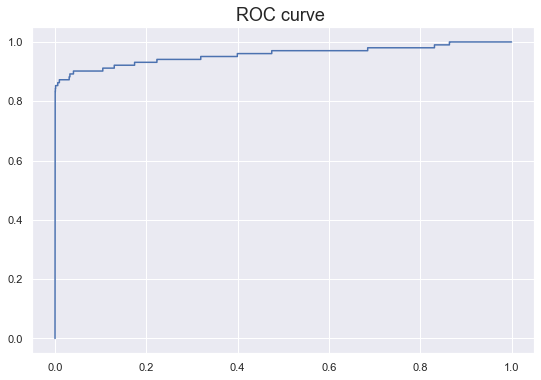

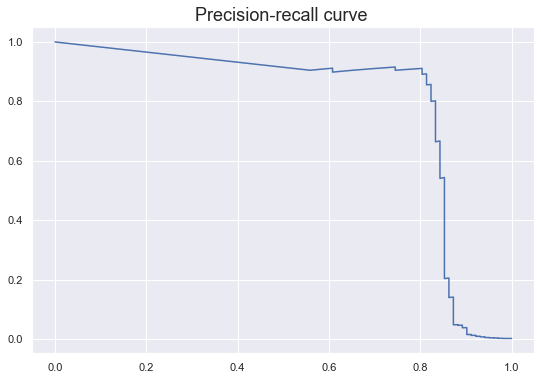

AUC for ROC: 0.9575169721059481
AUC for precision-recall: 0.7968859425385454


In [146]:
probs = clf_smote.predict_proba(XX_val)
curve_eval(y_val, probs[:,1])

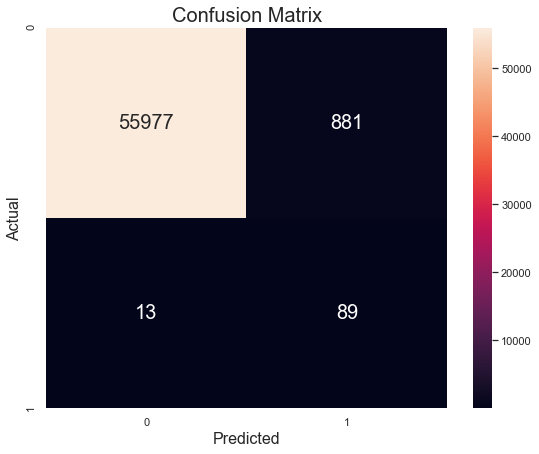

In [147]:
make_confusion_matrix(y_val, preds)

It looks like this is the same performance in terms of recall as last time, but the precision is reasonably better. Let's try to tune the hyperparameters to see if there's anything better.

In [148]:
threshold_reg_grid_search(X_train_smote, y_train_smote, XX_val, y_val, thresholds, c_vals)

Threshold: 0.4 C: 0.01    Recall: 0.87    Precision: 0.11
Threshold: 0.5 C: 0.1    Recall: 0.87    Precision: 0.11
Threshold: 0.6 C: 1    Recall: 0.87    Precision: 0.12
Threshold: 0.6 C: 10    Recall: 0.87    Precision: 0.11
Threshold: 0.6 C: 100    Recall: 0.87    Precision: 0.11
Threshold: 0.7 C: 10    Recall: 0.87    Precision: 0.14
Threshold: 0.7 C: 100    Recall: 0.87    Precision: 0.13


We see that the best hyperparameters on our validation set were given by threshold $=0.7,$ and $C=10.$ Sadly, SMOTE here did not significantly increase performance, but let us do a final check on the test set:

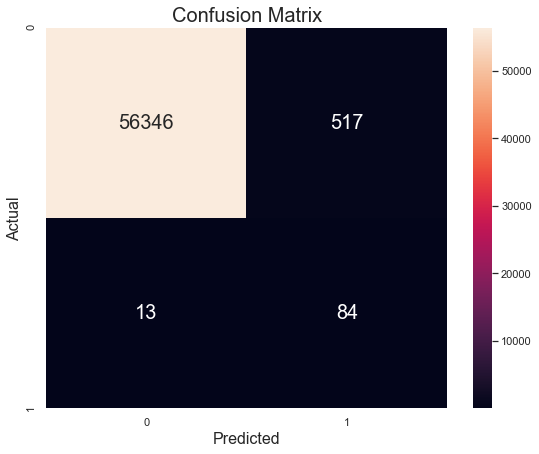

In [149]:
clf_smote_opt = LogisticRegression(C=10, random_state=0, solver='lbfgs')
clf_smote_opt.fit(X_train_smote, y_train_smote)
probs_test = clf_smote_opt.predict_proba(design_matrix(X_test))
preds_test = np.where(probs_test[:,1] > 0.7, 1, 0)
make_confusion_matrix(y_test, preds_test)

The recall turned out to be exactly the same: $84/(84+13)=86.6\%,$ but the precision is also around the same. Doing the calculations, it seems that about $0.9\%$ of perfectly fine credit card transactions will be flagged as possibly fraudulent, so the company will have to find ways for customers to easily verify their transactions.

### Logistic Regression with LASSO

Finally, let's check out the performance of logistic regression with L1-penalty. Now recall that L1 regularization is able to zero-out variables if they are insufficiently important to the model. This will depend on the hyperparameter $C$ in the loss function. Because of this, we can train and test out this model by using all the variables.

In [221]:
trainsmote = train_smote.drop(['Class'], axis=1)
Xdev = X_val.drop(['Time', 'Amount'], axis=1)

In [224]:
threshold_reg_grid_search(trainsmote, y_train_smote, Xdev, y_val, thresholds, c_vals, penalty='l1')

/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Threshold: 0.6 C: 0.01    Recall: 0.86    Precision: 0.13
Threshold: 0.6 C: 0.1    Recall: 0.86    Precision: 0.12
Threshold: 0.7 C: 0.1    Recall: 0.86    Precision: 0.16
Threshold: 0.7 C: 1    Recall: 0.86    Precision: 0.13
Threshold: 0.7 C: 10    Recall: 0.86    Precision: 0.12


/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Threshold: 0.7 C: 100    Recall: 0.86    Precision: 0.12
Threshold: 0.8 C: 1    Recall: 0.86    Precision: 0.16
Threshold: 0.8 C: 10    Recall: 0.86    Precision: 0.16
Threshold: 0.8 C: 100    Recall: 0.86    Precision: 0.15
Threshold: 0.9 C: 10    Recall: 0.86    Precision: 0.21
Threshold: 0.9 C: 100    Recall: 0.86    Precision: 0.2


/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

It seems that the optimal values for the hyperparameters are with $C=10$ and threshold equal to $0.9.$ The final result on our test set is the following:

/Users/jcp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


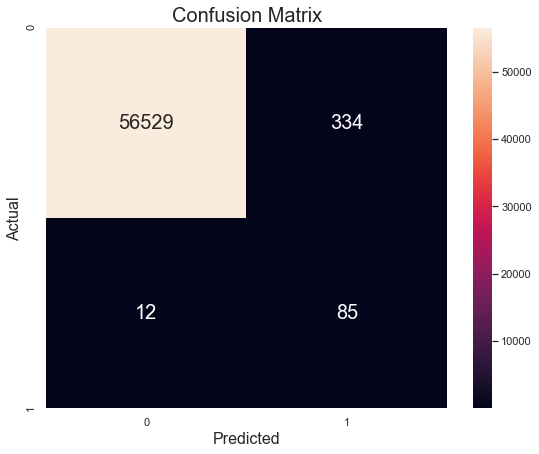

In [226]:
clf_smote_lasso_opt = LogisticRegression(C=10, random_state=0, penalty='l1')
clf_smote_lasso_opt.fit(trainsmote, y_train_smote)
probs_test = clf_smote_lasso_opt.predict_proba(X_test.drop(['Time', 'Amount'], axis=1))
preds_test = np.where(probs_test[:,1] > 0.9, 1, 0)
make_confusion_matrix(y_test, preds_test)

This is the best performance we have seen so far! The recall is $85/97=87.6\%,$ but the precision has increased substantially to $85/419=20.2\%.$ Thankfully, now only about $0.59\%$ of regular transactions will be flagged as fraudulent. In other words, about 1 in 170 regular transactions will be falsely marked as fraud. On the other hand, there are still about $12\%$ of fraudulent transactions being missed, so a more complex model should be considered. In the end, a simple model such as logistic regression with LASSO and a technique such as SMOTE is good enough for this performance! 

There is no doubt that more expressive models (random forests, neural networks) are bound to do better. A good next step is an error analysis: perhaps there is a pattern in the examples that are incorrectly labeled.

### References

Blagus, R., Lusa, L. SMOTE for high-dimensional class-imbalanced data. BMC Bioinformatics 14, 106 (2013). https://doi.org/10.1186/1471-2105-14-106